# Implementando AlexNet

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/08_AlexNet.ipynb)

AlexNet hizo historia en 2012, al ser la primera red realmente profunda y ganar con eso la competencia ILSVRC de clasificación sobre el dataset ImageNet. En general encontraremos una tendencia a intentar con modelos cada vez más profundos para mejorar la perfomance de los modelos.  

Además de hacer la red más profunda, para obtener un buen resultado se emplearon varias mejoras para acelerar el entrenamiento y técnicas para evitar el overfitting. 

Entre ellas se encuentran:

- Activaciones ReLu para evitar el problema de "la desaparición del gradiente"
- Entrenamiento en múltiples GPUs
- Data augmentation
- Normalización local (Local Response Normalization)
- Regularización L2
- Dropout

## Batch normalization

Presentado por primera vez por Ioffe y Szgedy en su artículo de 2015, [Batch Normalization: Accelerating Deep
Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167), Batch normalization es un tipo de capa que se utiliza para normalizar las activaciones de un volumen de entrada dado antes de pasarlo a la siguiente capa en la red. La idea es que esta normalización reduzca la magnitud del cambio en la distribución de activaciones de una época a la siguiente, de manera tal que las subsiguientes capas les sea más fácil aprender, ya que no tienen un input tan fluctuante.

Se ha demostrado que batch normalization es extremadamente eficaz para reducir el número de épocas que se necesitan para entrenar una red neuronal. También tiene el beneficio adicional de ayudar "estabilizar" el entrenamiento, lo que permite una mayor variedad de tasas de aprendizaje y factores de regularización. Una desventaja es que puede resultar en mayor tiempo de cómputo, porque los cálculos extra necesarios incrementan el tiempo de ejecución de cada época. 

Operativamente, lo que se hace es centrar y homogeneizar las activaciones a lo largo de cada batch. Es importante darse cuenta de que batch normalization no cancela ni
reduce el cambio en los valores unitarios ocultos. Lo que hace es asegurar que la distribución de ese cambio sigue siendo la misma: incluso si los valores exactos de las
activaciones cambian, la media y la varianza no cambian.

Esto se logra calculando el promedio y la varianza de las activaciones en cada batch:

$$\mu_\beta = \frac{1}{M}\sum_{i=1}^M a_i $$

$$\sigma_\beta^2 = \frac{1}{M}\sum_{i=1}^M (a_i - \mu_\beta)^2 $$

donde $M$ es el número de ejemplos en el batch, $\mu_\beta$ es el promedio y $\sigma_\beta^2$ la varianza.

Y normalizando las activaciones con:

$$ \hat{a_i} = \frac{a_i - \mu_\beta}{\sqrt{\sigma_\beta^2 + \epsilon}} $$

donde $\epsilon$ es igual a un pequeño valor positivo (como $1e-7$) para evitar tomar la raíz cuadrada de cero. 

Adicionalmente se escala y desplaza el resultado de la siguiente manera:

$$ y_i = \gamma a_i + \beta $$

donde $\gamma$ y $\beta$ son dos factores a aprender durante el entrenamientos. De esta forma cada capa de batch normalization agrega dos parámetros a la red

Es importante destacar que batch normalization funciona de manera diferente durante el entrenamiento y durante la inferencia.

**Durante el entrenamiento** (es decir, cuando se usa `fit()` o cuando se llama a la capa/modelo con el argumento `training=True`), la capa normaliza su salida usando la media y la desviación estándar del lote actual de entradas.

**Durante la inferencia** (es decir, cuando se usa `evaluate()` o `predict()` o cuando se llama a la capa/modelo con el argumento `training=False`), la capa normaliza su salida usando un promedio móvil de la media y la desviación estándar de los batches que ha visto durante el entrenamiento.

## Regularización

Si se observa que la red neuronal está sobreajustando los datos de entrenamiento, puede que la misma sea demasiado compleja y necesite ser simplificada. Una de las técnicas más importantes para eso es la regularización. En esta sección, discutiremos alguna de las técnicas más comunes de regularización: L2 y dropout.

### Regularización L2

La idea básica de la regularización L2 es agregar un término a la función de pérdida que penalice la magnitud de los pesos, esto hace que los pesos se mantengan pequeños, cercanos a cero y de esta forma ayuda a simplificar el modelo. El factor de regularización está dado por:

$$ L2 = \frac{\lambda}{2M} \sum \| w \|^2 $$

donde $w$ son los pesos, $\lambda$ es un factor de regularización y $M$ es el número de ejemplos en el batch.

$$ L_\text{new} = L_\text{old} + L2 $$

En la pŕactica, la regularización L2 no hace que los pesos sean iguales a cero. solo los hace más pequeños para reducir su efecto. Cuando los pesos se vuelvan insignificantes, el modelo no aprenderá mucho de esas unidades, lo que en definitiva equivale a matar algunas neuronas. Esto simplificará la red y, por lo tanto, reducirá el sobreajuste.

En keras, las regularización se aplica por capa. La API exacta dependerá de la capa, pero muchas capas (por ejemplo, Dense, Conv1D, Conv2D y Conv3D) tienen una API unificada.

### Dropout

Dropout es otra técnica de regularización muy eficaz para simplificar una red neuronal y evitar el sobreajuste. En cada iteración de entrenamiento, cada neurona tiene un
probabilidad $p$ de ser temporalmente ignorada (abandonada) durante esta iteración de entrenamiento. La probabilidad $p$ es un hiperparámetro que se denomina tasa de dropout y normalmente se establece en el rango de $0.3$ a $0.5$.

Tanto la regularización L2 como el dropout tienen como objetivo reducir la complejidad de la red al reducir la eficacia de las neuronas.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_datasets as tfds
import numpy as np
import seaborn as sns
sns.set_theme()

2023-07-02 14:36:37.140515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.config.list_physical_devices()

2023-07-02 14:36:38.926030: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:36:38.929540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:36:38.929685: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras.regularizers import l2

Arquitectura AlexNet

<!-- ![La arquitectura de AlexNet](images/alexnet_architecture.png) -->

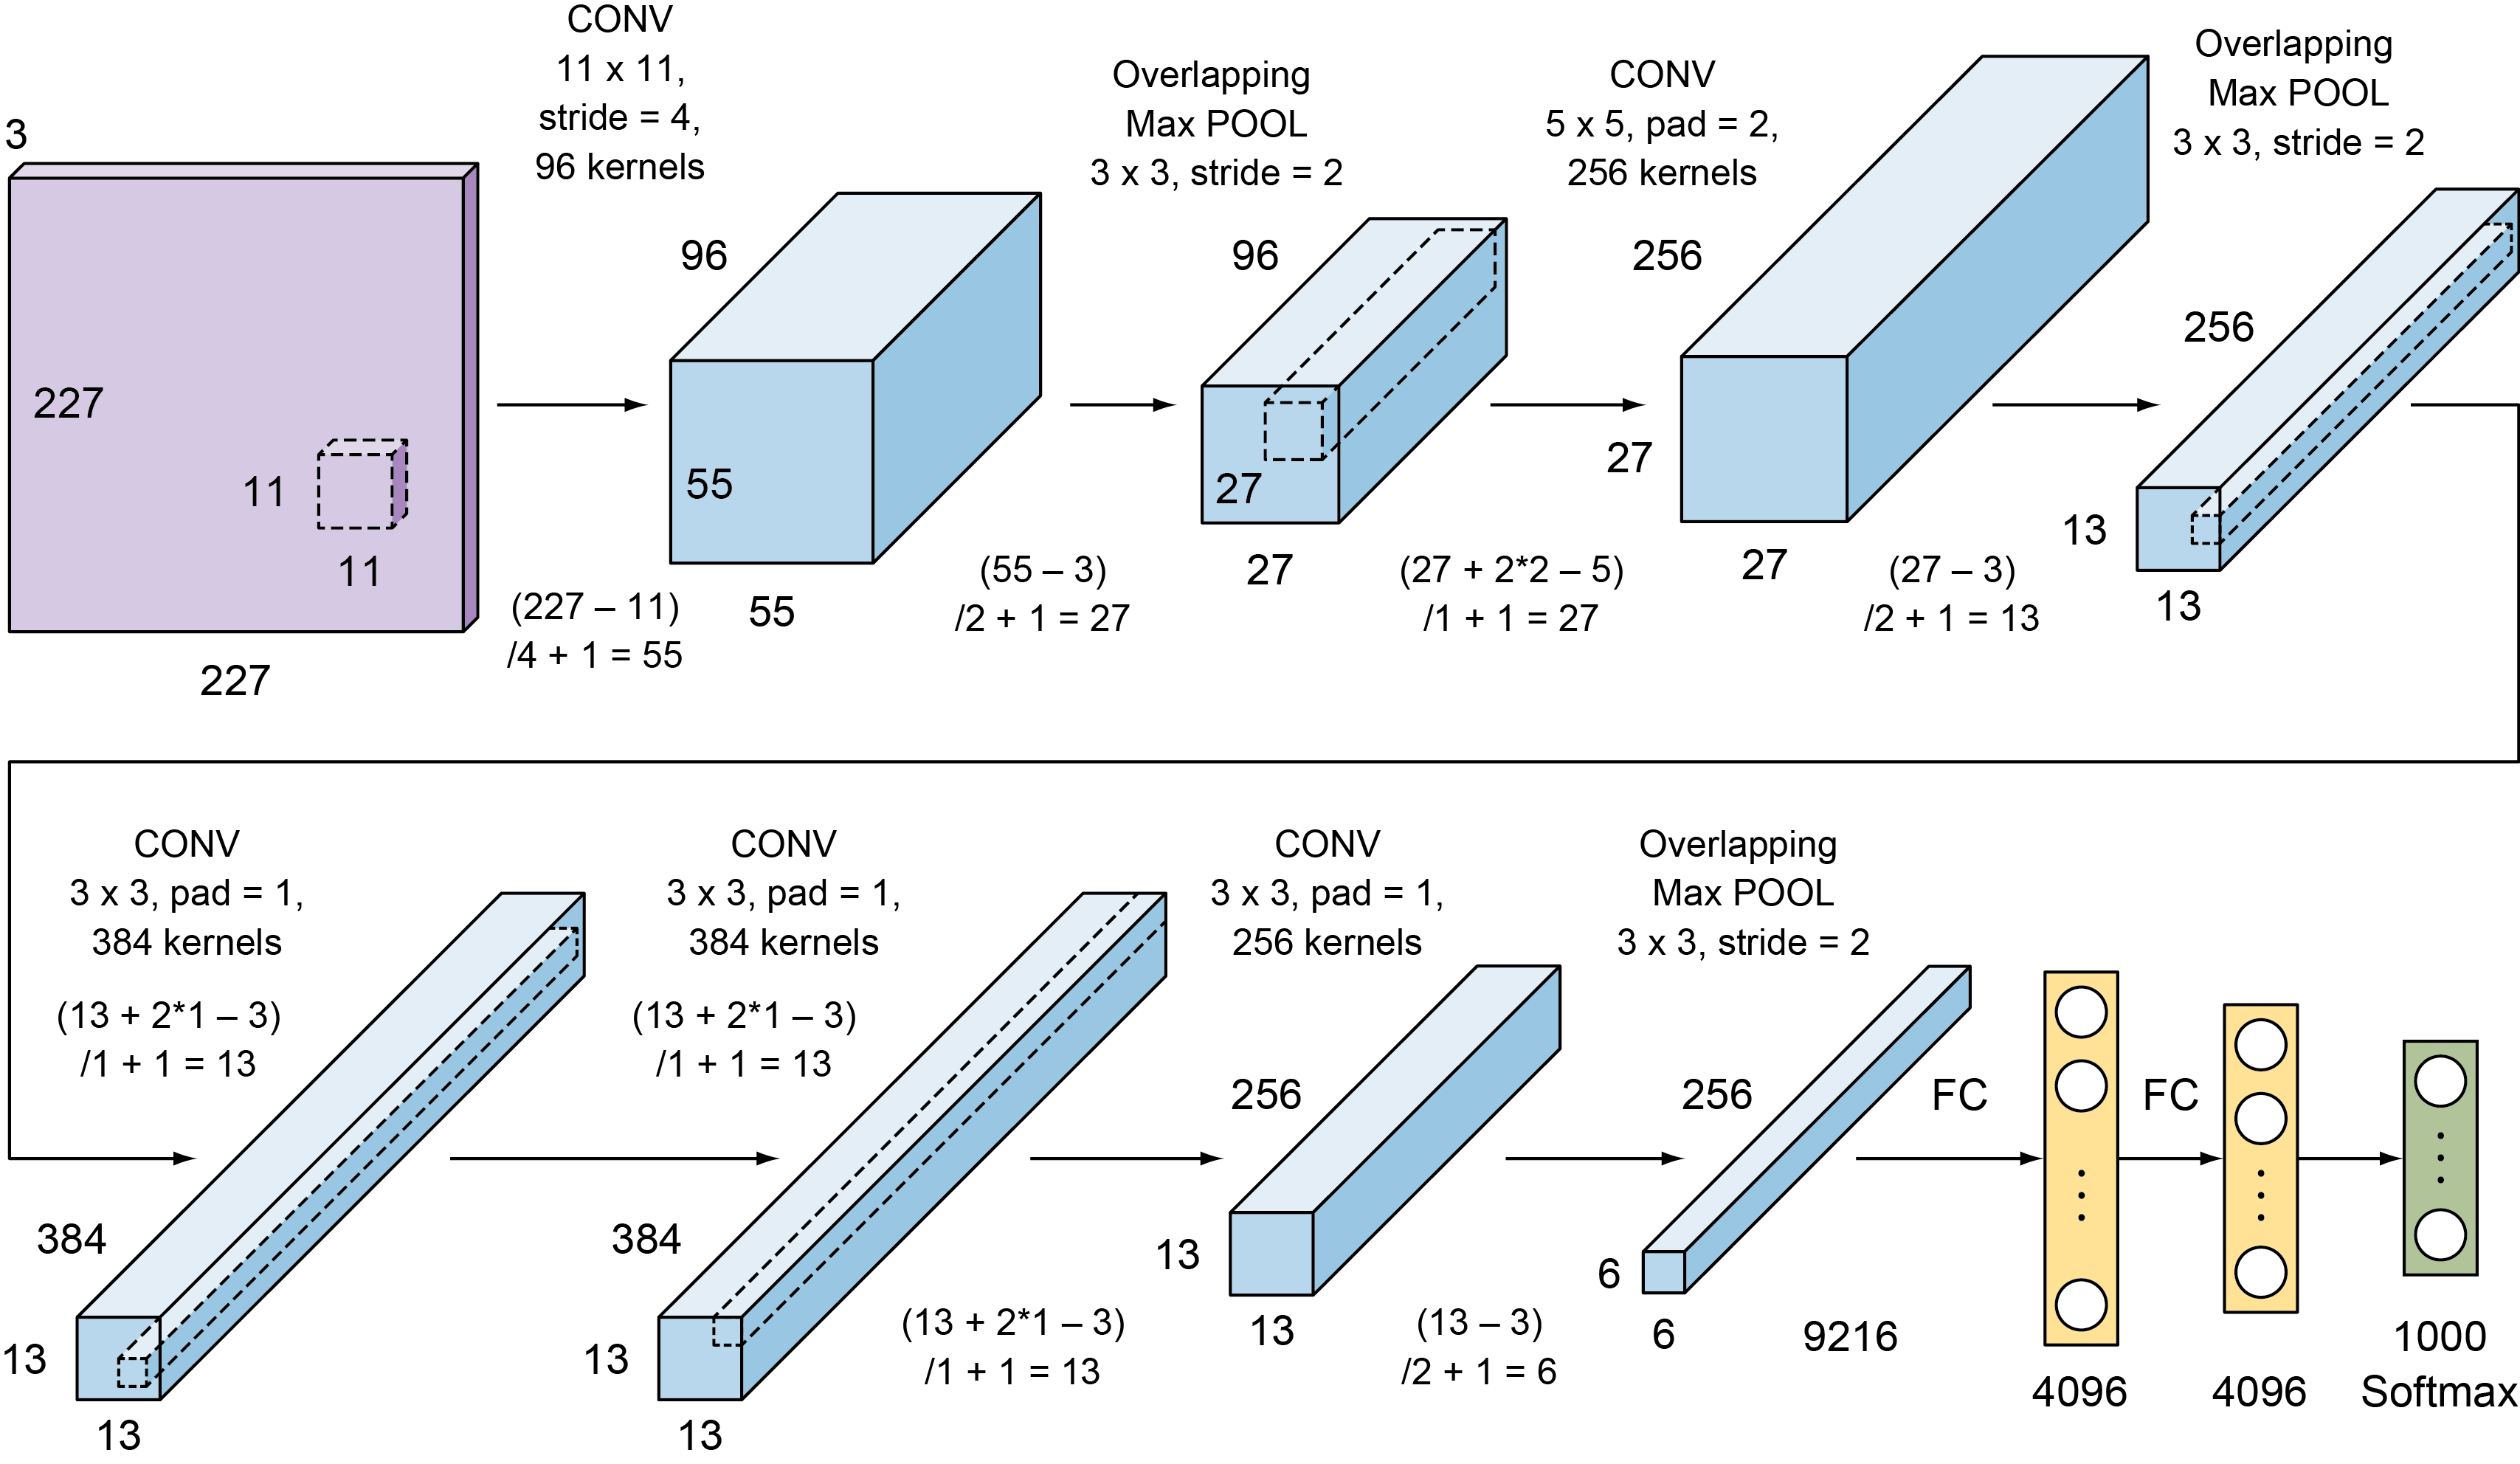

In [4]:
def create_AlexNet(input_shape=[227, 227, 3], num_classes=1000, activation="relu", pooling_layer=layers.MaxPooling2D, batch_normalization=True, kernel_regularizer=l2(5e-4)):
    """Create a keras sequencial model based on the AlexNet architecture"""

    if input_shape == [227, 227, 3]:
        first_kernel_size = 11
        pool_size = 3
    else:
        first_kernel_size = 3
        pool_size = 2

    model = Sequential()
    
    model.add(layers.Conv2D(filters=96, kernel_size=first_kernel_size, strides=4, activation=activation, padding="valid", input_shape=input_shape))
    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=256, kernel_size=5, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=384, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=384, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=256, kernel_size=3, strides=1, activation=activation, padding="same", kernel_regularizer=kernel_regularizer))
    if batch_normalization:
        model.add(layers.BatchNormalization())

    model.add(pooling_layer(pool_size=pool_size, strides=2, padding="valid"))

    model.add(layers.Flatten())

    model.add(layers.Dense(units=4096, activation=activation))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(units=4096, activation=activation))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(units=num_classes, activation="softmax"))

    return model

In [5]:
num_classes = 10


AlexNet = create_AlexNet(input_shape=[32, 32, 3], num_classes=num_classes, batch_normalization=False, kernel_regularizer=None)

AlexNet.summary()

2023-07-02 14:36:38.974479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:36:38.974678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 14:36:38.974811: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          2688      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 384)         1

In [6]:
# Data loading and preprocessing

(train_data, validation_data), info = tfds.load('cifar10', split=["train", "test"], with_info=True, as_supervised=True)

2023-07-02 14:36:39.568569: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /home/user/tensorflow_datasets/cifar10/3.0.2.incompleteO3W1E8/cifar10-train.tfrecord*...:   0%|     …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /home/user/tensorflow_datasets/cifar10/3.0.2.incompleteO3W1E8/cifar10-test.tfrecord*...:   0%|      …

Dataset cifar10 downloaded and prepared to /home/user/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [7]:
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpmfonhv0ctfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mul

2023-07-02 14:37:43.325189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 14:37:43.325417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-07-02 14:37:43.348711: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

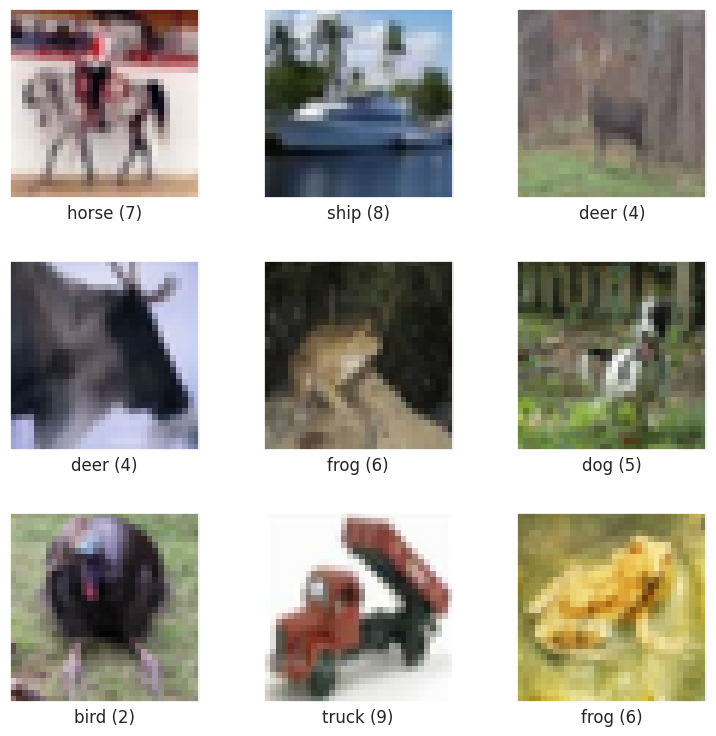

In [8]:
tfds.visualization.show_examples(train_data, info);

In [9]:
def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def to_categorical(image, label):
    return image, tf.one_hot(tf.cast(label, tf.int32), num_classes)

def pipeline(dataset):
    dataset = dataset.map(normalize)
    dataset = dataset.map(to_categorical)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train[:75%]'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 32

batched_train_data = processed_train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

Otro aspecto importante de la implementación es el uso de "momento" durante la optimización. Es muy común al utilizar SGD que se generen oscilaciones no deseadas en la dirección perpendicular al gradiente. Para evitar estas oscilaciones es que se invento el "momento" que incita al optimizador a moverse en la dirección del mínimo y reducir oscilaciones, esto lo logra aumentando el tamaño del paso en la dirección del mínimo y disminuyendolo en las otras. 

<!-- ![Oscilaciones no desceadas en el camino hacia el mínimo](images/momentum.png) -->

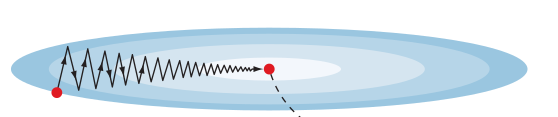

En términos matemáticos esto se logra modificando la ecuación de la actualización de los pesos, por otra ecuación que contempla adicionalmente un término de velocidad, este termino no es más que el promedio pesado de los gradientes anteriores. 

El efecto es que se produce un efecto "bola de nieve" en donde el optimizador comienza acumular momento en la dirección de mayor tasa de descenso, logrando una convergencia más rápida. Al mismo tiempo, el momento tiene la habilidad de hacer el entrenamiento más estable y que todo el procedimiento sea menos sensible al parámetro de la tasa de aprendizaje, es decir, que un rango mayor de tasas de aprendizaje resulten en una solucion potable. Y en consecuencia, que la elección de tasa de aprendizaje sea más sencilla.

Un buen artículo con una buena visualización se encuentra en [este link](https://distill.pub/2017/momentum/)

En nuestra solución también vamos a trabajar con un callback especial, `ReduceLROnPlateau` que disminuye automáticamente el learning rate cuando se entanca el progreso

In [10]:
lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=np.sqrt(0.1))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

AlexNet.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [11]:
history = AlexNet.fit(
    batched_train_data,
    epochs=50,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)

Epoch 1/50


2023-07-02 14:37:43.775969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 14:37:43.776403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 14:37:45.438027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-02 14:37:45.903070: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-02 14:37:4

1563/1563 [==============================] - ETA: 0s - loss: 2.3007 - accuracy: 0.1187

2023-07-02 14:37:52.432553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-07-02 14:37:52.432993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


1563/1563 [==============================] - 9s 4ms/step - loss: 2.3007 - accuracy: 0.1187 - val_loss: 2.2956 - val_accuracy: 0.1524 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 2.2465 - accuracy: 0.1692 - val_loss: 2.1039 - val_accuracy: 0.1926 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 2.0386 - accuracy: 0.2049 - val_loss: 1.9743 - val_accuracy: 0.2273 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.9227 - accuracy: 0.2402 - val_loss: 1.8101 - val_accuracy: 0.2870 - lr: 0.0010
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.7776 - accuracy: 0.3101 - val_loss: 1.7444 - val_accuracy: 0.3453 - lr: 0.0010
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 1.6732 - accuracy: 0.3591 - val_loss: 1.5922 - val_accuracy: 0.3885 - lr: 0.0010
Epoch 7/50
1563/1563 [==============================] - 6s 4ms/step -

<Axes: >

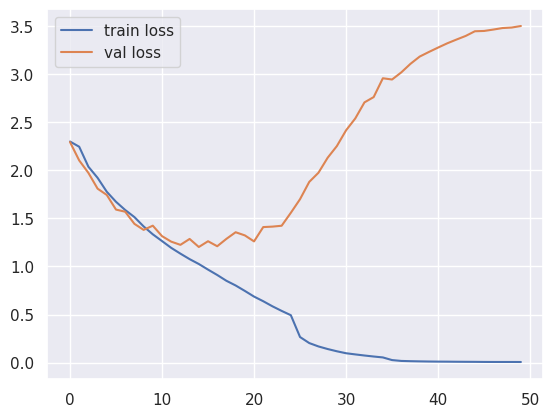

In [12]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

<Axes: >

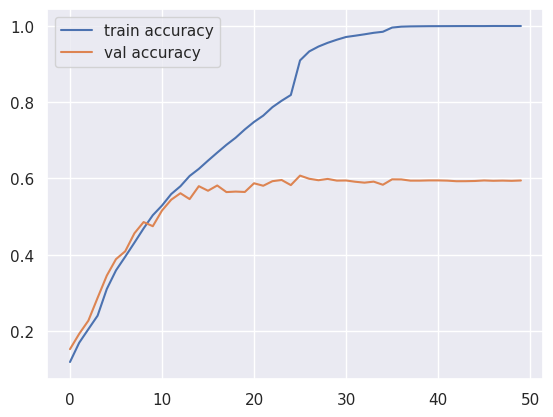

In [13]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")

## Data augmentation

Una forma de evitar el overfitting es obtener más datos. Como esto no siempre es posible, una opción es aumentar nuestros datos de entrenamiento generando nuevas instancias de la misma imágenes con algunas transformaciones. El aumento de datos puede ser una forma económica de alimentar a nuestros modelos con más datos de entrenamiento y, por lo tanto, reducir el overfitting.

En el contexto de las imágenes, algunas transformaciones posibles son:

- Traslaciones
- Rotaciones
- Cambios de escala
- Deformaciones
- Espejado (vertical u horizontal)
- Perturbaciones del espacio de colores
- Ajustes de brillo, contraste y saturación

<!-- ![Data augmentation](images/data_augmentation.png) -->

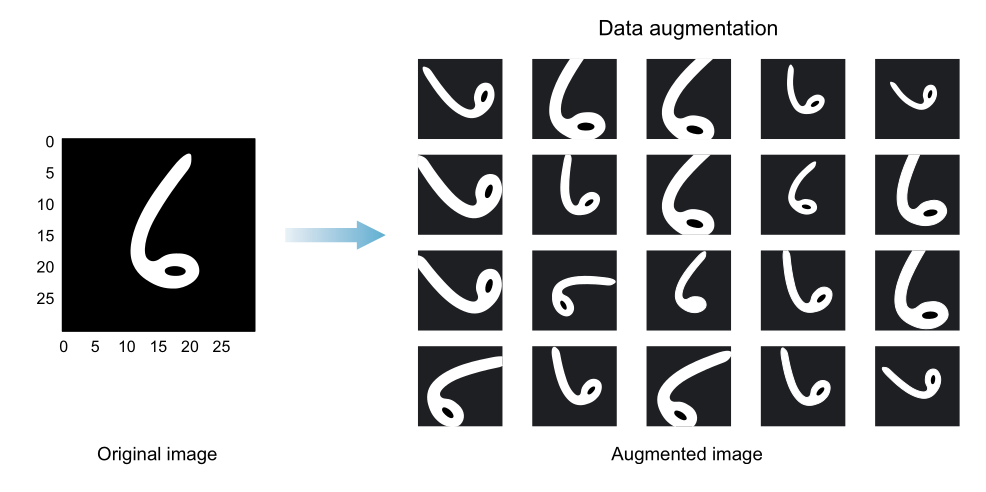

Hay que tener en cuenta que no todas las transformaciones tendrán sentido en todos los casos, en general se busca que la transformación no destruya el sentido semántico de la imagen, es decir que la etiqueta sea todavía reconocible a pesar de la transformación. Por ejemplo, en el caso de símbolos que tienen orientaciones canónicas definidas, hacer una transformación de espejado podría destruir parte de la información de la imagen.

TensorFlow ofrece varios mecanismos para hacer data augmentation de imágenes, el [módulo `tf.image`](https://www.tensorflow.org/api_docs/python/tf/image) tiene muchas operaciones útiles. 

Alternativamente, Keras ofrece capas específicamente diseñadas para data augmentation, se las puede identificar porque suelen referirse a `preprocessing` en la [documentación](https://www.tensorflow.org/api_docs/python/tf/keras/layers). Estas capas tienen un funcionamiento especial, ya que por defecto solamente están activas durante el entrenamiento y se desactivan automáticamente durante la inferencia. Pueden ser útiles para empaquetar el preprocesamiento dentro del modelo, en vez de depender de tener disponible también una pipeline de preprocesamiento. Además, las capas integradas al modelo van a correr en la GPU en vez de la CPU, lo cual puede resultar en tiempos de cómputo más cortos.

De cualquier modo todas las estas operaciones y capas se pueden integrar fácilmente al mecanismo de `tf.data.Dataset`









Muchos tutoriales, especialmente los más antiguos recomiendan utilizar `tf.keras.preprocessing.image.ImageDataGenerator`, sin embargo, eso está desaconsejado en las últimas versiónes de TensorFLow, [según la documentación](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator):

> Deprecated: tf.keras.preprocessing.image.ImageDataGenerator is not recommended for new code. Prefer loading images with tf.keras.utils.image_dataset_from_directory and transforming the output tf.data.Dataset with preprocessing layers



A continumación creamos un modelo del tipo `Sequential` que solo contiene capas para hacer data augmentation.

In [14]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomZoom((-0.2, 0.2)),
  layers.RandomTranslation(
    (-0.1, 0.1), (-0.1, 0.1)
  ),
  layers.RandomRotation(0.2),
])

Podemos ahora agrupar los datos de entrenamiento en batchs y luego aplicar `data_augmentation` utilizando `map`, como si se tratara de cualquier otra función.

Notemos que con esto, las operaciones de `data_augmentation` se aplican simultaneamente sobre todo el batch, lo que las hace más eficientes. 

In [15]:
batched_train_data = processed_train_data.batch(batch_size)


batched_train_data = batched_train_data.map(lambda x, y: (data_augmentation(x), y))

Visualizemos el resulta de `data_augmentation`

2023-07-02 14:42:52.342269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype resource
	 [[{{node Placeholder/_37}}]]
2023-07-02 14:42:52.342636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


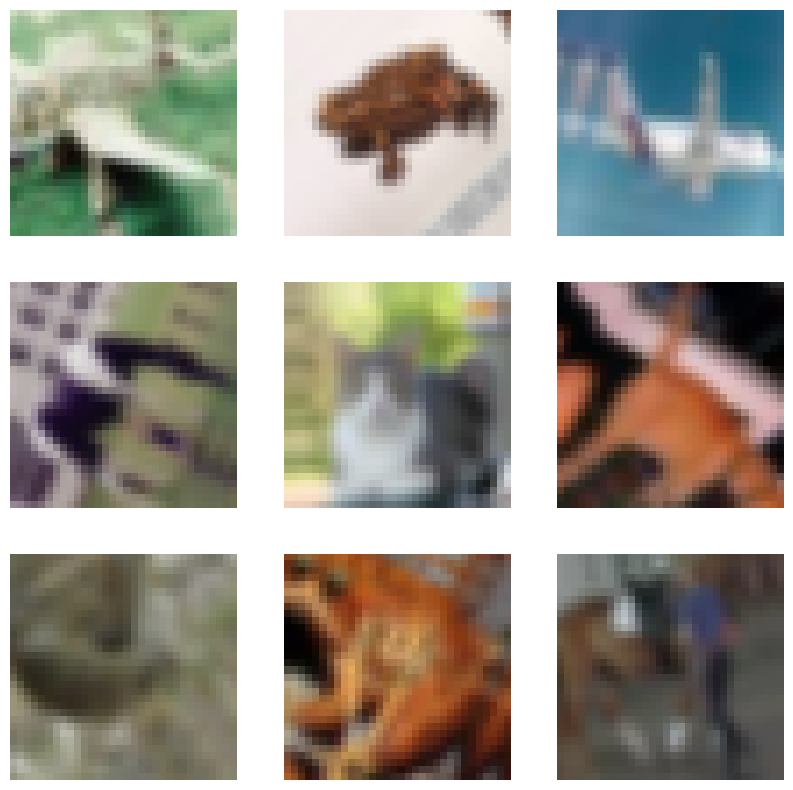

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in batched_train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")

Y finalmente entrenemos el modelo

In [17]:
history = AlexNet.fit(
    batched_train_data,
    epochs=50,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)

Epoch 1/50
  11/1563 [..............................] - ETA: 8s - loss: 5.5398 - accuracy: 0.4091 

2023-07-02 14:42:53.056128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-02 14:42:53.056494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_36' with dtype resource
	 [[{{node Placeholder/_36}}]]


1563/1563 [==============================] - 10s 6ms/step - loss: 2.2315 - accuracy: 0.4043 - val_loss: 1.5994 - val_accuracy: 0.5037 - lr: 3.1623e-05
Epoch 2/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5785 - accuracy: 0.4383 - val_loss: 1.5085 - val_accuracy: 0.5123 - lr: 3.1623e-05
Epoch 3/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5276 - accuracy: 0.4536 - val_loss: 1.4608 - val_accuracy: 0.5255 - lr: 3.1623e-05
Epoch 4/50
1563/1563 [==============================] - 10s 6ms/step - loss: 1.5071 - accuracy: 0.4580 - val_loss: 1.4321 - val_accuracy: 0.5254 - lr: 3.1623e-05
Epoch 5/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4886 - accuracy: 0.4681 - val_loss: 1.3636 - val_accuracy: 0.5381 - lr: 3.1623e-05
Epoch 6/50
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4695 - accuracy: 0.4735 - val_loss: 1.4580 - val_accuracy: 0.5225 - lr: 3.1623e-05
Epoch 7/50
1563/1563 [===================

<Axes: >

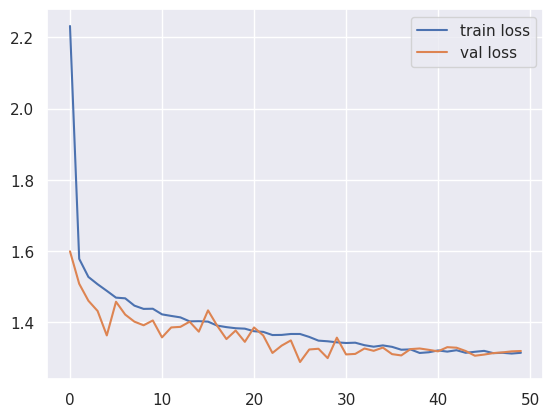

In [18]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

<Axes: >

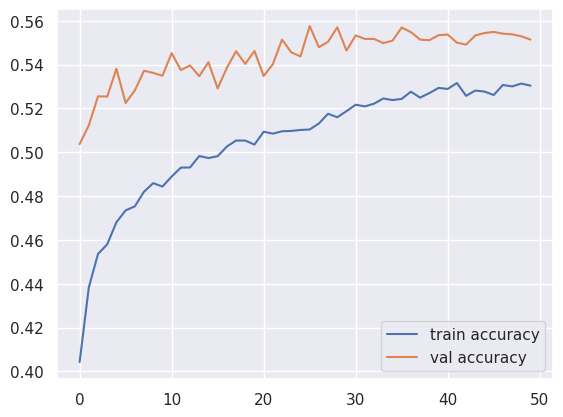

In [19]:
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label="train accuracy")
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label="val accuracy")